In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

# data load & 전처리

### train data

In [2]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [3]:
df_date_x = df_merge['date_x'].copy()
df_date_y = df_merge['date_y'].copy()

In [4]:
df_merge.drop(['date_x', 'date_y'], axis=1, inplace=True)

In [5]:
df_merge = df_merge.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

##### add Past days, week

In [6]:
df_merge.insert(loc=2 ,column='date_x', value=df_date_x)
df_merge.insert(loc=3 ,column='Past days_x', value=(df_merge['date_x'] - pd._libs.tslib.Timestamp('2022-07-17 00:00:00')))
df_merge.insert(loc=4 ,column='week_x', value=df_merge['date_x'].dt.weekday)
# df_merge.insert(loc=3 ,column='date_year_x', value=df_date_x.dt.year)
# df_merge.insert(loc=4 ,column='date_month_x', value=df_date_x.dt.month)
# df_merge.insert(loc=5 ,column='date_day_x', value=df_date_x.dt.day)
df_merge['Past days_x']=(pd.to_numeric(df_merge['Past days_x'])/86400000000000).astype(int)

df_merge.insert(loc=18 ,column='date_y', value=df_date_y)
df_merge.insert(loc=19 ,column='Past days_y', value=(df_merge['date_y'] - pd._libs.tslib.Timestamp('2020-05-18 00:00:00')))
df_merge.insert(loc=20 ,column='week_y', value=df_merge['date_y'].dt.weekday)
# df_merge.insert(loc=19 ,column='date_year_y', value=df_date_y.dt.year)
# df_merge.insert(loc=20 ,column='date_month_y', value=df_date_y.dt.month)
# df_merge.insert(loc=21 ,column='date_day_y', value=df_date_y.dt.day)
df_merge['Past days_y']=(pd.to_numeric(df_merge['Past days_y'])/86400000000000).astype(int)

### test data

In [ ]:
# df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
# df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')
# df_date_x_test = df_merge_test['date_x'].copy()
# df_date_y_test = df_merge_test['date_y'].copy()

# df_merge_test.drop(['date_x', 'date_y'], axis=1, inplace=True)

# df_merge_test = df_merge_test.replace('type ', '', regex=True).apply(pd.to_numeric, errors='ignore')

# df_merge_test.insert(loc=2 ,column='date_x', value=df_date_x_test)
# df_merge_test.insert(loc=3 ,column='Past days_x', value=(df_merge_test['date_x'] - pd._libs.tslib.Timestamp('2022-07-17 00:00:00')))
# df_merge_test.insert(loc=4 ,column='week_x', value=df_merge_test['date_x'].dt.weekday)
# # df_merge_test.insert(loc=3 ,column='date_year_x', value=df_date_x_test.dt.year)
# # df_merge_test.insert(loc=4 ,column='date_month_x', value=df_date_x_test.dt.month)
# # df_merge_test.insert(loc=5 ,column='date_day_x', value=df_date_x_test.dt.day)

# df_merge_test.insert(loc=18 ,column='date_y', value=df_date_y_test)
# df_merge_test.insert(loc=19 ,column='Past days_y', value=(df_merge_test['date_y'] - pd._libs.tslib.Timestamp('2020-05-18 00:00:00')))
# df_merge_test.insert(loc=20 ,column='week_y', value=df_merge_test['date_y'].dt.weekday)
# # df_merge_test.insert(loc=19 ,column='date_year_y', value=df_date_y_test.dt.year)
# # df_merge_test.insert(loc=20 ,column='date_month_y', value=df_date_y_test.dt.month)
# # df_merge_test.insert(loc=21 ,column='date_day_y', value=df_date_y_test.dt.day)

In [11]:
del df_train, df_people, df_date_x, df_date_y
# del df_test, df_date_x_test, df_date_y_test

In [ ]:
# df_merge.to_csv("train_merge.csv")

# EDA

In [7]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



In [8]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()

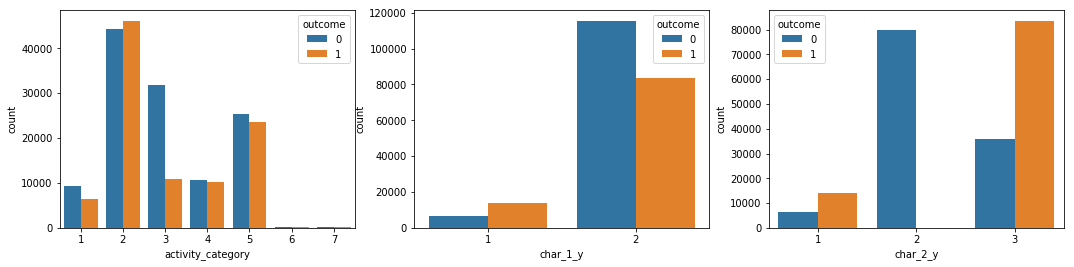

In [9]:
plt.figure(figsize=(18,4))
for i, feat in enumerate(['activity_category', 'char_1_y', 'char_2_y']):
    plt.subplot(1,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [12]:
plt.plot(df_sample['Past days_x'])
plt.show()

OverflowError: In draw_path: Exceeded cell block limit

# modeling

In [ ]:
df_tree = df_sample[['activity_category', 'date_x', 'char_38', 'char_1_y', 'char_2_y','outcome']].copy()

In [ ]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=['activity_category', 'char_38', 'char_1_y', 'char_2_y'])
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

In [ ]:
df_tree_X = df_sample[['activity_category', 'date_x', 'char_1_y', 'char_2_y','char_38']].copy()
df_tree_y = df_sample['outcome'].copy()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_tree_X, df_tree_y)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df_tree_y, tree.predict(df_tree_X))